In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()
df = pd.DataFrame(cursor.execute("""select * from combined5""").fetchall())
df.columns = [description[0] for description in cursor.description]
df = df.drop(columns=["index", "level_0"])
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,plant_name_gen,operator_name_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month_nerc,number_affected,disturbance_events
0,5.4,23.100,0.0,0.49,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,259412,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
1,5.7,22.800,0.0,0.48,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,52241,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
2,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-1-SERC,0.0,0.0
3,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-1-SERC,0.0,0.0
4,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-1-SERC,0.0,0.0


In [3]:
other_fields = [ 'average_heat_content',  'average_sulfur_content',  'contract_type',  'energy_source',  'fuel_cost',  'fuel_group',   'operator_id',  'operator_name',  'plant_id',  'plant_name',  'plant_state',  'primary_transportation_mode',  'purchase_type',  'quantity',  'regulated',  'reporting_frequency',  'secondary_transportation_mode',  'supplier',   'combined_heat_and_power_plant', 'census_region',  'nerc_region',  'reserved_',  'naics_code',  'eia_sector_number',  'sector_name',  'reported_prime_mover',  'reported_fuel_type_code',   'reserved_1',  'reserved_2',  'net_generation_megawatthours', 'mmbtu_per_unit_gen',  'number_affected',  'disturbance_events']

In [59]:
df_c.energy_source.value_counts()

DFO    30521
RFO     1925
PC      1542
WO       212
JF       129
PG       115
OG        93
KER       71
SGP       36
Name: energy_source, dtype: int64

# Checking Correlations

In [126]:
# Label encode categorical fields so that they can be correlated
df_c = df[(df["fuel_group"] != "Coal") & (df["fuel_group"] != "Natural Gas")][other_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_c[other_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_c[not_encode].reset_index()
temp2 = df_c[to_encode].apply(le.fit_transform).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [127]:
corr = df_c.corr()

In [123]:
df_c = df[(df["fuel_group"] != "Coal") & (df["fuel_group"] != "Natural Gas")][other_fields]

In [124]:
df_c[ 'physical_unit_label'].value_counts()

barrels       32858
short tons     1542
mcf             244
Name: physical_unit_label, dtype: int64

In [118]:
df_c['aer_fuel_type_code'].value_counts()

DFO    30521
RFO     1925
PC      1578
WOO      459
OOG      161
Name: aer_fuel_type_code, dtype: int64

In [128]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['energy_source', 'energy_source', 1.0],
 ['average_heat_content', 'average_sulfur_content', 0.9649279649072806],
 ['average_sulfur_content', 'average_heat_content', 0.9649279649072806],
 ['average_heat_content', 'fuel_group', 0.9516121186540857],
 ['fuel_group', 'average_heat_content', 0.9516121186540857],
 ['number_affected', 'disturbance_events', 0.9143572557451818],
 ['disturbance_events', 'number_affected', 0.9143572557451818],
 ['average_sulfur_content', 'fuel_group', 0.8996131797551545],
 ['fuel_group', 'average_sulfur_content', 0.8996131797551545],
 ['naics_code', 'eia_sector_number', 0.8703864526952163],
 ['eia_sector_number', 'naics_code', 0.8703864526952163],
 ['average_heat_content', 'mmbtu_per_unit_gen', 0.7651639164569584],
 ['mmbtu_per_unit_gen', 'average_heat_content', 0.7651639164569584],
 ['eia_sector_number', 'sector_name', 0.7543181005715996],
 ['average_sulfur_content', 'mmbtu_per_unit_gen', 0.7514837871195463],
 ['mmbtu_per_unit_gen', 'average_sulfur_content', 0.

Some obvious correlations in here, like disturbance events and number affected (by disturbance events) similar for natural gas, or coalmine state and energy source, which is just coal type in this subset. It helps give an idea of the data, but it doesn't indicate any changes to features.

Heat content is interesting as it is possibly a major feature in determining fuel cost — potentially a direct gauge of fuel quality.

### Checking Correlations Involving Fuel Cost

In [129]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'primary_transportation_mode', 0.1538877195737925],
 ['fuel_cost', 'operator_name', 0.0607169736067394],
 ['fuel_cost', 'plant_name', 0.04333338360244734],
 ['fuel_cost', 'plant_state', 0.03586010108726362],
 ['fuel_cost', 'number_affected', 0.03397989455039198],
 ['fuel_cost', 'disturbance_events', 0.031381827615769166],
 ['fuel_cost', 'contract_type', 0.03097663550018397],
 ['fuel_cost', 'sector_name', 0.008104666984432008],
 ['fuel_cost', 'secondary_transportation_mode', 0.007408041900625748],
 ['fuel_cost', 'eia_sector_number', 0.006927968443166159],
 ['fuel_cost', 'naics_code', 0.003870984036544876],
 ['fuel_cost', 'purchase_type', -0.013828589877877887],
 ['fuel_cost', 'nerc_region', -0.029213310673417037],
 ['fuel_cost', 'supplier', -0.0496780870662802],
 ['fuel_cost', 'plant_id', -0.05008987844157455],
 ['fuel_cost', 'census_region', -0.05457217651780664],
 ['fuel_cost', 'reporting_frequency', -0.0591378000667756],
 ['fuel_cost', 'operator_id', -0.065797764299077

Heat and ash content decently correlated with fuel cost makes sense as those can be direct factors of fuel quality for coal. Operator may be interesting to explore later.

Chlorine content is also interesting as it involves coal and environmental regulation.

# Modelling

In [4]:
def get_c():
    df_c = df[(df["fuel_group"] != "Coal") & (df["fuel_group"] != "Natural Gas")][other_fields]
    not_encode = []
    to_encode = []
    for fld, fld_type in df_c[other_fields].dtypes.items():
        if "object" == fld_type:
            to_encode.append(fld)
        else:
            not_encode.append(fld)
    temp1 = df_c[not_encode].reset_index()
    temp2 = pd.get_dummies(df_c[to_encode]).reset_index()
    df_c = temp1.merge(temp2, on="index").set_index("index")
    return df_c


In [ ]:
df_c = get_c()

In [64]:
X = df_c.drop(columns=["fuel_cost"])
y = (df_c.fuel_cost > df_c.fuel_cost.quantile(.9))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [65]:
model = DecisionTreeClassifier(random_state=23)
results = model.fit(X_train, y_train)

In [66]:
results.score(X_test, y_test)

0.94429210564295

In [67]:
cross_val_score(results, X, y, cv=5)

array([0.47633478, 0.41939674, 0.92466445, 0.70929561, 0.90184758])

Definitely some inconsistencies in cross_val_score. Definitely needs SMOTE because of data imbalance.

In [68]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

month 0.12130929492961749
year_gen 0.0826337687747348
quantity 0.07184812620741807
supplier_PACIFIC BIODIESEL 0.06144312604491716
average_heat_content 0.055623014937754296
year 0.03364584361077427
mmbtu_per_unit_gen 0.013420336259597637
netgen_gen 0.010187401078300847
net_generation_megawatthours 0.009398528621580901
elec_quantity_gen 0.00897582385465588
reporting_frequency_M 0.008835057935553753
nerc_region_WECC 0.00880054045585485
elec_mmbtu_gen 0.008261903050447297
average_sulfur_content 0.008236071655946205
census_region_PACN 0.007670294306825407
operator_id_7140.0 0.007634336006724503
electric_fuel_consumption_quantity 0.006585993764074214
quantity_gen 0.006321206489139594
total_fuel_consumption_quantity 0.005694515001275664
operator_name_Dayton Power & Light Co 0.005621606807946075
supplier_SYSTEM FUELS 0.005541477934788054
operator_name_gen_City of Tallahassee 0.005488608634328208
tot_mmbtu_gen 0.005446277329709035
year_month_nerc_2012-3-SERC 0.005309229596394014
elec_fuel_consu

energy_source_KER 0.0
energy_source_OG 0.0
energy_source_PC 0.0
energy_source_PG 0.0
energy_source_SGP 0.0
energy_source_WO 0.0
fuel_group_Other Gas 0.0
fuel_group_Petroleum 0.0
fuel_group_Petroleum Coke 0.0
operator_id_10005.0 0.0
operator_id_10071.0 0.0
operator_id_10171.0 0.0
operator_id_10620.0 0.0
operator_id_11018.0 0.0
operator_id_11208.0 0.0
operator_id_11241.0 0.0
operator_id_11249.0 0.0
operator_id_11269.0 0.0
operator_id_11479.0 0.0
operator_id_11571.0 0.0
operator_id_11701.0 0.0
operator_id_11732.0 0.0
operator_id_11740.0 0.0
operator_id_11806.0 0.0
operator_id_11843.0 0.0
operator_id_12199.0 0.0
operator_id_12208.0 0.0
operator_id_12341.0 0.0
operator_id_12647.0 0.0
operator_id_12667.0 0.0
operator_id_12685.0 0.0
operator_id_12686.0 0.0
operator_id_12710.0 0.0
operator_id_12745.0 0.0
operator_id_12807.0 0.0
operator_id_12927.0 0.0
operator_id_13143.0 0.0
operator_id_13337.0 0.0
operator_id_13478.0 0.0
operator_id_13488.0 0.0
operator_id_13683.0 0.0
operator_id_13781.0 0.0


plant_name_Parr GT 0.0
plant_name_Picway 0.0
plant_name_Plant No 2 0.0
plant_name_Plant X 0.0
plant_name_Pleasant Prairie 0.0
plant_name_Pleasant Valley 0.0
plant_name_Pleasant Valley (MN) 0.0
plant_name_Polk 0.0
plant_name_Port Allen 0.0
plant_name_Port Allen (HI) 0.0
plant_name_Port Everglades 0.0
plant_name_Possum Point 0.0
plant_name_Potter Station 2 0.0
plant_name_Powerlane Plant 0.0
plant_name_Prairie Creek 0.0
plant_name_Presque Isle 0.0
plant_name_Pulliam 0.0
plant_name_Putnam 0.0
plant_name_Pyramid 0.0
plant_name_Quindaro 0.0
plant_name_R D Green 0.0
plant_name_R D Morrow 0.0
plant_name_R S Nelson 0.0
plant_name_Rawhide 0.0
plant_name_Ray D Nixon 0.0
plant_name_Remington 0.0
plant_name_Rex Brown 0.0
plant_name_Richard M Flynn 0.0
plant_name_Richmond 0.0
plant_name_River Rouge 0.0
plant_name_Riverbend 0.0
plant_name_Riverside 0.0
plant_name_Riverton 0.0
plant_name_Rivesville 0.0
plant_name_Riviera 0.0
plant_name_Robert A Reid 0.0
plant_name_Robert E Ritchie 0.0
plant_name_Rober

plant_id_gen_8223 0.0
plant_id_gen_8224 0.0
plant_id_gen_856 0.0
plant_id_gen_8816 0.0
plant_id_gen_8823 0.0
plant_id_gen_8824 0.0
plant_id_gen_8825 0.0
plant_id_gen_8828 0.0
plant_id_gen_8843 0.0
plant_id_gen_964 0.0
plant_id_gen_976 0.0
plant_id_gen_983 0.0
plant_id_gen_988 0.0
plant_id_gen_99 0.0
plant_id_gen_990 0.0
combined_heat_and_power_plant_N 0.0
combined_heat_and_power_plant_Y 0.0
plant_name_gen_500MW CC 0.0
plant_name_gen_A B Brown 0.0
plant_name_gen_A L Pierce 0.0
plant_name_gen_AES Petersburg 0.0
plant_name_gen_Agua Fria 0.0
plant_name_gen_Albright 0.0
plant_name_gen_Allen S King 0.0
plant_name_gen_Allen Steam Plant 0.0
plant_name_gen_Altavista Power Station 0.0
plant_name_gen_Ames Electric Services Power Plant 0.0
plant_name_gen_Ames GT 0.0
plant_name_gen_Anchorage 1 0.0
plant_name_gen_Anclote 0.0
plant_name_gen_Anderson 0.0
plant_name_gen_Angus Anson 0.0
plant_name_gen_Anson County Generation Facility 0.0
plant_name_gen_Antelope Valley 0.0
plant_name_gen_Apache Station 0

year_month_nerc_2008-10-ASCC 0.0
year_month_nerc_2008-10-FRCC 0.0
year_month_nerc_2008-10-HICC 0.0
year_month_nerc_2008-10-MRO 0.0
year_month_nerc_2008-10-NPCC 0.0
year_month_nerc_2008-10-None 0.0
year_month_nerc_2008-10-RFC 0.0
year_month_nerc_2008-10-SERC 0.0
year_month_nerc_2008-10-SPP 0.0
year_month_nerc_2008-10-TRE 0.0
year_month_nerc_2008-10-WECC 0.0
year_month_nerc_2008-11-ASCC 0.0
year_month_nerc_2008-11-FRCC 0.0
year_month_nerc_2008-11-HICC 0.0
year_month_nerc_2008-11-MRO 0.0
year_month_nerc_2008-11-NPCC 0.0
year_month_nerc_2008-11-None 0.0
year_month_nerc_2008-11-RFC 0.0
year_month_nerc_2008-11-SERC 0.0
year_month_nerc_2008-11-SPP 0.0
year_month_nerc_2008-11-TRE 0.0
year_month_nerc_2008-11-WECC 0.0
year_month_nerc_2008-12-ASCC 0.0
year_month_nerc_2008-12-FRCC 0.0
year_month_nerc_2008-12-HICC 0.0
year_month_nerc_2008-12-MRO 0.0
year_month_nerc_2008-12-NPCC 0.0
year_month_nerc_2008-12-None 0.0
year_month_nerc_2008-12-SERC 0.0
year_month_nerc_2008-12-SPP 0.0
year_month_nerc_2008

year_month_nerc_2012-8-FRCC 0.0
year_month_nerc_2012-8-NPCC 0.0
year_month_nerc_2012-8-None 0.0
year_month_nerc_2012-8-TRE 0.0
year_month_nerc_2012-8-WECC 0.0
year_month_nerc_2012-9-ASCC 0.0
year_month_nerc_2012-9-HICC 0.0
year_month_nerc_2012-9-NPCC 0.0
year_month_nerc_2012-9-None 0.0
year_month_nerc_2012-9-SPP 0.0
year_month_nerc_2012-9-TRE 0.0
year_month_nerc_2013-1-FRCC 0.0
year_month_nerc_2013-1-HICC 0.0
year_month_nerc_2013-1-NPCC 0.0
year_month_nerc_2013-1-None 0.0
year_month_nerc_2013-1-SPP 0.0
year_month_nerc_2013-1-WECC 0.0
year_month_nerc_2013-10-FRCC 0.0
year_month_nerc_2013-10-MRO 0.0
year_month_nerc_2013-10-NPCC 0.0
year_month_nerc_2013-10-None 0.0
year_month_nerc_2013-10-SERC 0.0
year_month_nerc_2013-10-SPP 0.0
year_month_nerc_2013-10-TRE 0.0
year_month_nerc_2013-11-FRCC 0.0
year_month_nerc_2013-11-HICC 0.0
year_month_nerc_2013-11-MRO 0.0
year_month_nerc_2013-11-NPCC 0.0
year_month_nerc_2013-11-None 0.0
year_month_nerc_2013-11-RFC 0.0
year_month_nerc_2013-11-SERC 0.0
yea

In [71]:
y_pred = results.predict(X_test)

In [72]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
conf

In [73]:
conf

,0,1
0,6068,189
1,197,475


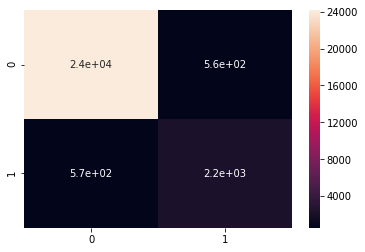

In [110]:
sns.heatmap(conf, annot=True)

In [74]:
f1_score(y_test, y_pred)

0.7110778443113772

F1 score without SMOTE is decent, but applying SMOTE anyway to try and improve.

In [75]:
# Show imbalance of data
len(df_c[df_c.fuel_cost > df_c.fuel_cost.quantile(.9)])/len(df_c)

0.09995958896201362

# Modelling with SMOTE

In [130]:
df_c = get_c()

In [131]:
X = df_c.drop(columns=["fuel_cost"])
y = (df_c.fuel_cost > df_c.fuel_cost.quantile(.9))

In [132]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2)

In [133]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [134]:
y_pred = results.predict(X_test)

In [135]:
f1_score(y_test, y_pred)

0.815815649867374

Much better F1-score. But let's see if we can improve.

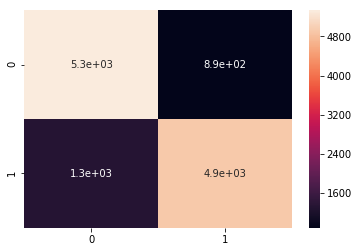

In [136]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [137]:
conf

,0,1
0,5330,892
1,1330,4921


In [138]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

nerc_region_SERC 0.24185873953666323
contract_type_C 0.13712104620152696
purchase_type_S 0.12770684469261587
average_heat_content 0.11117238233955512
supplier_PACIFIC BIODIESEL 0.04800235790794945
contract_type_S 0.04259025085861091
quantity 0.03402826110728797
net_generation_megawatthours 0.03103317543755927
census_region_ESC  0.03011595452623549
plant_state_IL 0.024780122019135275
plant_id_642 0.01689057542269363
supplier_Boswell Oil 0.013246803949196084
mmbtu_per_unit_gen 0.01270313441119836
plant_id_6474 0.010148489627749432
nerc_region_RFC 0.009498528742419039
average_sulfur_content 0.009254147052542705
supplier_MARATHON PETROLEUM 0.006906994084338974
plant_name_North Pole 0.006789686258626285
disturbance_events 0.006386767950155299
supplier_TESORO 0.0057337049814225535
nerc_region_WECC 0.005364250308476367
supplier_FARSTAD 0.005309020136290812
supplier_JOHN E RETZNER OIL 0.005203176748897324
supplier_PILOT TRAVEL CENTERS LLC 0.004539270781772193
supplier_FRAZIER OIL CO 0.00401178

plant_id_2161 0.0
plant_id_2167 0.0
plant_id_2168 0.0
plant_id_2169 0.0
plant_id_2176 0.0
plant_id_2226 0.0
plant_id_2241 0.0
plant_id_2265 0.0
plant_id_2266 0.0
plant_id_2271 0.0
plant_id_2290 0.0
plant_id_2292 0.0
plant_id_2364 0.0
plant_id_2367 0.0
plant_id_2434 0.0
plant_id_2451 0.0
plant_id_246 0.0
plant_id_2491 0.0
plant_id_2493 0.0
plant_id_2511 0.0
plant_id_2514 0.0
plant_id_2516 0.0
plant_id_2517 0.0
plant_id_2518 0.0
plant_id_2521 0.0
plant_id_26 0.0
plant_id_2679 0.0
plant_id_2682 0.0
plant_id_2706 0.0
plant_id_2708 0.0
plant_id_2709 0.0
plant_id_2712 0.0
plant_id_2713 0.0
plant_id_2716 0.0
plant_id_2718 0.0
plant_id_2720 0.0
plant_id_2721 0.0
plant_id_2723 0.0
plant_id_2727 0.0
plant_id_2732 0.0
plant_id_2817 0.0
plant_id_2823 0.0
plant_id_2824 0.0
plant_id_2828 0.0
plant_id_2830 0.0
plant_id_2832 0.0
plant_id_2840 0.0
plant_id_2843 0.0
plant_id_2847 0.0
plant_id_2848 0.0
plant_id_2850 0.0
plant_id_2872 0.0
plant_id_2876 0.0
plant_id_2936 0.0
plant_id_2953 0.0
plant_id_2964

supplier_CHEVRON 0.0
supplier_CHIEF PETROLEUM 0.0
supplier_CHRISTMAN FUEL SERVICE 0.0
supplier_CHS REFINERY 0.0
supplier_CITGO 0.0
supplier_CLOUGH OIL COMPANY 0.0
supplier_COAL CREEK 0.0
supplier_COAL ENERGY 0.0
supplier_COLONIAL 0.0
supplier_COLONIAL OIL 0.0
supplier_COMO 0.0
supplier_COMO OIL 0.0
supplier_COMPANIA GENERAL 0.0
supplier_CONOCO 0.0
supplier_CONOCOPHILLIPS 0.0
supplier_CONSOLIDATED ENERGY COMPANY 0.0
supplier_CONTINENTAL REFINING COMPANY 0.0
supplier_CORAL 0.0
supplier_CORRIGAN OIL COMPANY 0.0
supplier_COULSON 0.0
supplier_COUNTRYSIDE COOPERATIVE 0.0
supplier_CRESCENT OIL COMPANY 0.0
supplier_CROSS PETROLEUM 0.0
supplier_CRYSTAL FLASH 0.0
supplier_CUSTOM FUEL SERVICES 0.0
supplier_Cenex of Washburn 0.0
supplier_Central States Petroleum Inc. 0.0
supplier_Clark Oil 0.0
supplier_DALE PETROLEUM 0.0
supplier_DANNY'S SERVICE 0.0
supplier_DAVISON 0.0
supplier_DELTA GROWERS ASSOCIATION 0.0
supplier_DELTA WESTERN 0.0
supplier_DENNIS K BURKE 0.0
supplier_DIAL OIL 0.0
supplier_DIAM

# Analyze False Positives and Negatives

In [139]:
# Reload data label-encoded for correlation
# Label encode categorical fields so that they can be correlated
df_c = df[(df["fuel_group"] != "Coal") & (df["fuel_group"] != "Natural Gas")][other_fields]

not_encode = []
to_encode = []
for fld, fld_type in df_c[other_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_c[not_encode].reset_index()
temp2 = df_c[to_encode].apply(le.fit_transform).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [140]:
y_pred = results.predict(X)

In [141]:
wrongs = (y_pred != y)

### Append the wrong flag on the dataframe so we can analyze and subset

In [142]:
df_c["wrong"] = wrongs

In [143]:
df_c = df_c[df_c["wrong"] == True].drop(columns="wrong")

### Correlations on the Dataset of Innaccurate Predictions

In [161]:
corr = df_c.corr()
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=False)
corrs[0:20]  

[['average_heat_content', 'fuel_cost', -0.453979511405097],
 ['fuel_cost', 'average_heat_content', -0.453979511405097],
 ['average_sulfur_content', 'fuel_cost', -0.4452030302484556],
 ['fuel_cost', 'average_sulfur_content', -0.4452030302484556],
 ['fuel_cost', 'mmbtu_per_unit_gen', -0.33620260779264177],
 ['mmbtu_per_unit_gen', 'fuel_cost', -0.33620260779264177],
 ['fuel_cost', 'net_generation_megawatthours', -0.29987933530410393],
 ['net_generation_megawatthours', 'fuel_cost', -0.29987933530410393],
 ['fuel_cost', 'quantity', -0.08619096091239592],
 ['quantity', 'fuel_cost', -0.08619096091239592],
 ['fuel_cost', 'naics_code', 0.003870984036544876],
 ['naics_code', 'fuel_cost', 0.003870984036544876],
 ['fuel_cost', 'eia_sector_number', 0.006927968443166159],
 ['eia_sector_number', 'fuel_cost', 0.006927968443166159],
 ['fuel_cost', 'disturbance_events', 0.031381827615769166],
 ['disturbance_events', 'fuel_cost', 0.031381827615769166],
 ['fuel_cost', 'number_affected', 0.0339798945503919

Largest correlation of inaccurate predictions involves chlorine content. But looking at other top correlations too.

In [149]:
df_c = df[(df["fuel_group"] != "Coal") & (df["fuel_group"] != "Natural Gas")][other_fields]


In [151]:
df_c["wrong"] = wrongs

In [175]:
df_c[df_c["wrong"]== True]["contract_type"].value_counts()/len(df_c[df_c["wrong"]== True])

S      0.640212
C      0.193496
N/A    0.165808
NC     0.000483
Name: contract_type, dtype: float64

In [173]:
df_c[(df_c["wrong"]== True) & (df_c["energy_source"] == "DFO")].head(100)

,average_heat_content,average_sulfur_content,contract_type,energy_source,fuel_cost,fuel_group,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,combined_heat_and_power_plant,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,reserved_1,reserved_2,net_generation_megawatthours,mmbtu_per_unit_gen,number_affected,disturbance_events,wrong
74,5.544,0.30,S,DFO,2209.0,Petroleum,213.0,Alaska Electric Light&Power Co,64,Lemon Creek,AK,TR,N/A,9196,REG,M,N/A,NAME PENDING,N,PACN,ASCC,None,22,1,Electric Utility,GT,DFO,None,None,5066,0.00,0.0,0.0,True
75,5.544,0.30,S,DFO,2209.0,Petroleum,213.0,Alaska Electric Light&Power Co,64,Lemon Creek,AK,TR,N/A,9196,REG,M,N/A,NAME PENDING,N,PACN,ASCC,None,22,1,Electric Utility,IC,DFO,None,None,23297,5.54,0.0,0.0,True
91,5.820,0.00,S,DFO,2188.6,Petroleum,15500.0,Puget Sound Energy Inc,99,Frederickson,WA,TR,N/A,958,REG,A,TR,DON SMALL & SONS OIL DISTRIBUTION CO,N,PACC,WECC,None,22,1,Electric Utility,GT,DFO,None,None,5354,5.53,0.0,0.0,True
180,5.800,0.35,C,DFO,1891.3,Petroleum,9617.0,JEA,207,St Johns River Power Park,FL,TR,N/A,2170,REG,M,N/A,COLONIAL OIL,N,SAT,FRCC,None,22,1,Electric Utility,ST,DFO,None,None,21066,5.76,0.0,0.0,True
313,5.800,0.10,S,DFO,1961.7,Petroleum,14610.0,Orlando Utilities Comm,564,Stanton Energy Center,FL,TR,N/A,533,REG,M,N/A,ROYAL PETROLEUM,N,SAT,FRCC,None,22,1,Electric Utility,ST,DFO,None,None,0,0.00,0.0,0.0,True
363,5.824,0.00,C,DFO,1934.4,Petroleum,7801.0,Gulf Power Co,643,Lansing Smith,FL,TR,N/A,181,REG,M,N/A,Petroleum Traders,N,SAT,SERC,None,22,1,Electric Utility,GT,DFO,None,None,124,5.82,0.0,0.0,True
395,5.796,0.06,S,DFO,1933.9,Petroleum,10623.0,City of Lakeland,675,Larsen Memorial,FL,TR,N/A,149,REG,A,N/A,FLEETWING,N,SAT,FRCC,None,22,1,Electric Utility,CA,DFO,None,None,388,0.00,0.0,0.0,True
480,5.800,0.01,S,DFO,1894.2,Petroleum,17828.0,City of Springfield - (IL),964,Lakeside,IL,TR,N/A,177,REG,A,N/A,MANSFIELD,N,ENC,SERC,None,22,1,Electric Utility,IC,DFO,None,None,0,0.00,0.0,0.0,True
481,5.800,0.01,S,DFO,1894.2,Petroleum,17828.0,City of Springfield - (IL),964,Lakeside,IL,TR,N/A,177,REG,A,N/A,MANSFIELD,N,ENC,SERC,None,22,1,Electric Utility,ST,DFO,None,None,656,5.80,0.0,0.0,True
498,5.712,0.30,S,DFO,2102.4,Petroleum,9269.0,Indiana-Kentucky Electric Corp,983,Clifty Creek,IN,TR,N/A,1096,REG,M,N/A,Key Oil,N,ENC,RFC,None,22,1,Electric Utility,ST,DFO,None,None,4499,0.00,0.0,0.0,True


In [174]:
df_c["contract_type"].value_counts()

N/A    14909
S      11399
C       8252
NC        84
Name: contract_type, dtype: int64

In [160]:
df_c["plant_state"].value_counts()[0:10]/len(df_c)

MI    0.106801
HI    0.087144
FL    0.081544
KY    0.071008
IN    0.056142
MO    0.049128
NC    0.042432
VA    0.038390
SC    0.037698
OH    0.030308
Name: plant_state, dtype: float64

In [159]:
df_c[df_c["wrong"]== True]["plant_state"].value_counts()/len(df_c[df_c["wrong"]== True])

MI    0.167257
FL    0.098680
OH    0.067289
IN    0.054411
CO    0.053284
MO    0.050386
HI    0.041050
IA    0.040889
MN    0.033323
KY    0.030586
ND    0.029942
NY    0.027366
TX    0.025435
AK    0.022376
WV    0.021893
WY    0.018030
SC    0.017547
NM    0.017386
GA    0.016581
AZ    0.015937
NC    0.014166
WI    0.013844
UT    0.013200
KS    0.012395
NE    0.011751
NH    0.011269
OK    0.009337
VA    0.009176
MT    0.009176
MA    0.008371
IL    0.008210
AL    0.005151
NV    0.004668
OR    0.003381
TN    0.003220
LA    0.003220
WA    0.002576
CA    0.002254
AR    0.001771
SD    0.001449
CT    0.000644
NJ    0.000483
VT    0.000322
MS    0.000322
Name: plant_state, dtype: float64

## Subsetting the data - Only Spot Contracts

In [117]:
df_c = get_c()
df_c2 = df_c[(df_c["contract_type_S"] ==1)].copy()

In [118]:
X = df_c2.drop(columns="fuel_cost")
y = (df_c2.fuel_cost > df_c.fuel_cost.quantile(.9))

In [119]:
sm = SMOTE(random_state=23, k_neighbors=10, m_neighbors=5)
X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2)

In [120]:
model = DecisionTreeClassifier(random_state=23)
results = model.fit(X_train, y_train)

In [121]:
y_pred = results.predict(X_test)

In [103]:
f1_score(y_test, y_pred)

0.9309838472834068

F1-score was struggling in the mid-80s, so I removed the max-depth for just this subset.

In [104]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

quantity 0.14415897279240253
nerc_region_SERC 0.10936012461269759
net_generation_megawatthours 0.057073038186021746
average_sulfur_content 0.0516953961772551
nerc_region_RFC 0.04443954763249175
mmbtu_per_unit_gen 0.041632028037159416
census_region_WNC  0.030875093487956768
census_region_ESC  0.025581594782359763
average_heat_content 0.021199386515079386
number_affected 0.01924861534673866
census_region_MTN  0.01796204751307559
plant_name_Harbor Beach 0.01752331890583326
primary_transportation_mode_TR 0.017208537832148117
supplier_MARATHON ASHLAND PETROLEUM 0.016219217747336933
operator_name_Detroit Edison Co 0.014994869826150123
census_region_SAT  0.014605198310468057
operator_name_Dayton Power & Light Co 0.013818762946400538
operator_id_13337.0 0.01288545360619545
nerc_region_WECC 0.012707893962387883
supplier_KENTUCKY PETROLEUM 0.010859116545017812
census_region_MTN 0.010616642927097075
operator_id_18445.0 0.010303179689334873
reporting_frequency_A 0.0100293408763807
census_region_EN

plant_id_2122 0.0
plant_id_2123 0.0
plant_id_2132 0.0
plant_id_2144 0.0
plant_id_2161 0.0
plant_id_2167 0.0
plant_id_2168 0.0
plant_id_2169 0.0
plant_id_2226 0.0
plant_id_2241 0.0
plant_id_2266 0.0
plant_id_2271 0.0
plant_id_2290 0.0
plant_id_2292 0.0
plant_id_2364 0.0
plant_id_2367 0.0
plant_id_2434 0.0
plant_id_2451 0.0
plant_id_246 0.0
plant_id_2491 0.0
plant_id_2493 0.0
plant_id_2511 0.0
plant_id_2514 0.0
plant_id_2516 0.0
plant_id_2517 0.0
plant_id_2518 0.0
plant_id_2521 0.0
plant_id_26 0.0
plant_id_2679 0.0
plant_id_2682 0.0
plant_id_2706 0.0
plant_id_2708 0.0
plant_id_2709 0.0
plant_id_2712 0.0
plant_id_2713 0.0
plant_id_2716 0.0
plant_id_2718 0.0
plant_id_2720 0.0
plant_id_2721 0.0
plant_id_2723 0.0
plant_id_2727 0.0
plant_id_2732 0.0
plant_id_2817 0.0
plant_id_2823 0.0
plant_id_2828 0.0
plant_id_2830 0.0
plant_id_2832 0.0
plant_id_2840 0.0
plant_id_2843 0.0
plant_id_2847 0.0
plant_id_2848 0.0
plant_id_2850 0.0
plant_id_2872 0.0
plant_id_2876 0.0
plant_id_2936 0.0
plant_id_2953

supplier_ALLIED ENERGY, LLC 0.0
supplier_ALPHA COAL 0.0
supplier_AMERADA HESS 0.0
supplier_AMERICAN PRIDE 0.0
supplier_APEX 0.0
supplier_ARCADIA 0.0
supplier_ARCH 0.0
supplier_ASPHALT & FUEL SUPPLY 0.0
supplier_ATLAS OIL COMPANY 0.0
supplier_AVFUEL 0.0
supplier_B & W RESOURCES 0.0
supplier_B P PETROLEUM 0.0
supplier_BARTHOLOMEW OIL COMPANY 0.0
supplier_BAUMAN OIL 0.0
supplier_BEAUDRY OIL 0.0
supplier_BELMONT PETROLEUM 0.0
supplier_BENCHMARK BIODIESEL 0.0
supplier_BENCHMARKB 0.0
supplier_BEST OIL COMPANY 0.0
supplier_BIOENERGY SOLUTIONS 0.0
supplier_BLACKJEWEL MARKETING AND SALES, LLC. 0.0
supplier_BOMINFLOT ATLANTIC 0.0
supplier_BOSWELL 0.0
supplier_BOSWELL OIL CO 0.0
supplier_BP 0.0
supplier_BP NORTH AMERICA 0.0
supplier_BPE 0.0
supplier_BRADCO FUELS & LUBRICANTS 0.0
supplier_BRAUN OIL COMPANY 0.0
supplier_BRICK JEDA OIL CO 0.0
supplier_BRIGGS & TILLMAN 0.0
supplier_BRINER OIL CO 0.0
supplier_BROWNFIELD OIL 0.0
supplier_BRUCETON PETROLEUM 0.0
supplier_BUCKLEY 0.0
supplier_BULK PLANTS 

In [122]:
leaf1_test = y_test
leaf1_pred = y_pred

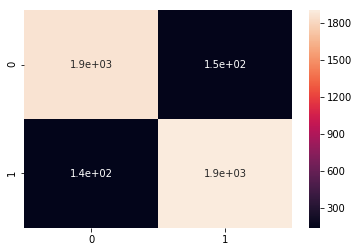

In [105]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [106]:
conf

,0,1
0,1866,146
1,136,1902


In [107]:
cross_val_score(results, X_res, y_res, cv=20)

array([0.65976331, 0.70512821, 0.71203156, 0.8816568 , 0.96936759,
       0.95454545, 0.9673913 , 0.96640316, 0.97628458, 0.96146245,
       0.93478261, 0.86857708, 0.97233202, 0.96245059, 0.9812253 ,
       0.97233202, 0.93083004, 0.90810277, 0.90316206, 0.86363636])

Some abberations in cross_val_score. Spot contracts for petroleum may be particularly volatile and hard to predict.

# Modeling Subset of Data - No Spot Contracts

In [5]:
df_c = get_c()
df_c3 = df_c[(df_c["contract_type_S"] != 1)]

In [6]:
X = df_c3.drop(columns="fuel_cost")
y = (df_c3.fuel_cost > df_c.fuel_cost.quantile(.9))
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2)

In [7]:
model = DecisionTreeClassifier(max_depth=10)
results = model.fit(X_train, y_train)

In [8]:
y_pred = results.predict(X_test)
f1_score(y_pred, y_test)

0.9494995973772

Great, good F1-Score on the other subset as well.

In [112]:
leaf2_pred = y_pred
leaf2_test = y_test

In [113]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

quantity 0.145422081442465
average_heat_content 0.10464294462464291
nerc_region_SERC 0.1016320788900496
purchase_type_S 0.08894709689571974
nerc_region_RFC 0.054451646224059874
net_generation_megawatthours 0.05273186416191047
average_sulfur_content 0.03394920071454597
contract_type_N/A 0.029912563825077437
purchase_type_C 0.0270332757903156
supplier_PACIFIC BIODIESEL 0.021713359178092216
mmbtu_per_unit_gen 0.021022062884807315
supplier_Boswell Oil 0.019144766858777494
purchase_type_N/A 0.014039621488936208
disturbance_events 0.01149598026563851
supplier_SUNRISE AG 0.011011823689244414
reporting_frequency_A 0.007860430934911648
census_region_ENC  0.007823499882656525
purchase_type_NC 0.00751135255039372
plant_name_Port Allen (HI) 0.007472925190363969
supplier_PILOT TRAVEL CENTERS LLC 0.0068906265026332245
supplier_MANSFIELD 0.006086687587912142
plant_name_Keahole 0.006065299792635038
supplier_MARATHON PETROLEUM 0.00604576872203205
supplier_TESORO 0.005148924311301934
supplier_BEST OIL C

plant_id_141 0.0
plant_id_1417 0.0
plant_id_1449 0.0
plant_id_147 0.0
plant_id_151 0.0
plant_id_160 0.0
plant_id_165 0.0
plant_id_1660 0.0
plant_id_167 0.0
plant_id_1678 0.0
plant_id_1682 0.0
plant_id_1702 0.0
plant_id_1710 0.0
plant_id_1720 0.0
plant_id_1723 0.0
plant_id_1729 0.0
plant_id_173 0.0
plant_id_1731 0.0
plant_id_1733 0.0
plant_id_1734 0.0
plant_id_1740 0.0
plant_id_1743 0.0
plant_id_1744 0.0
plant_id_1745 0.0
plant_id_1769 0.0
plant_id_1843 0.0
plant_id_1866 0.0
plant_id_1888 0.0
plant_id_1891 0.0
plant_id_1904 0.0
plant_id_1913 0.0
plant_id_1915 0.0
plant_id_1927 0.0
plant_id_1943 0.0
plant_id_2001 0.0
plant_id_201 0.0
plant_id_203 0.0
plant_id_2039 0.0
plant_id_2047 0.0
plant_id_2050 0.0
plant_id_2051 0.0
plant_id_2053 0.0
plant_id_207 0.0
plant_id_2076 0.0
plant_id_2080 0.0
plant_id_2081 0.0
plant_id_2094 0.0
plant_id_2098 0.0
plant_id_2104 0.0
plant_id_2122 0.0
plant_id_2123 0.0
plant_id_2132 0.0
plant_id_2144 0.0
plant_id_2161 0.0
plant_id_2168 0.0
plant_id_2169 0.0
pl

supplier_CASTLETON COMMODITIES MERCHANT TRADING LP 0.0
supplier_CENEX OF HAZEN 0.0
supplier_CENTRAL OIL 0.0
supplier_CENTRAL STATES PETROLEUM 0.0
supplier_CHASEBURG FARMER'S UNION 0.0
supplier_CHEMOIL 0.0
supplier_CHEMOIL CORPORATION 0.0
supplier_CHIEF PETROLEUM 0.0
supplier_CHRISTMAN FUEL SERVICE 0.0
supplier_CHS REFINERY 0.0
supplier_CITGO 0.0
supplier_CLOUGH OIL COMPANY 0.0
supplier_COAL CREEK 0.0
supplier_COAL ENERGY 0.0
supplier_COLONIAL OIL 0.0
supplier_COMO 0.0
supplier_COMPANIA GENERAL 0.0
supplier_CONOCO 0.0
supplier_CONOCOPHILLIPS 0.0
supplier_CONSOLIDATED ENERGY COMPANY 0.0
supplier_CORAL 0.0
supplier_CORRIGAN OIL COMPANY 0.0
supplier_COULSON 0.0
supplier_COUNTRYSIDE COOPERATIVE 0.0
supplier_CRESCENT OIL COMPANY 0.0
supplier_CROSS PETROLEUM 0.0
supplier_CRYSTAL FLASH 0.0
supplier_CUSTOM FUEL SERVICES 0.0
supplier_Central States Petroleum Inc. 0.0
supplier_Clark Oil 0.0
supplier_DALE PETROLEUM 0.0
supplier_DANNY'S SERVICE 0.0
supplier_DAVISON 0.0
supplier_DELTA GROWERS ASSOCI

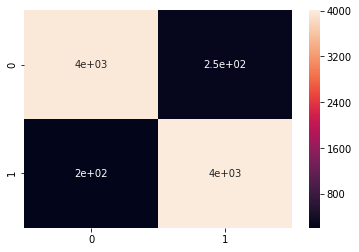

In [114]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [115]:
conf

,0,1
0,3969,248
1,203,4003


# Combine the Two Leafs to Find Out Combined F1 Score

In [123]:
leaf1_pred = pd.DataFrame(leaf1_pred)
leaf2_pred = pd.DataFrame(leaf2_pred)
leaf1_test = pd.DataFrame(leaf1_test)
leaf2_test = pd.DataFrame(leaf2_test)

leafs_pred = leaf1_pred.append(leaf2_pred)
leafs_test = leaf1_test.append(leaf2_test)

In [124]:
f1_score(leafs_pred, leafs_test)

0.940656869830563

In [9]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

In [10]:
from IPython.display import display                               
from ipywidgets import interactive

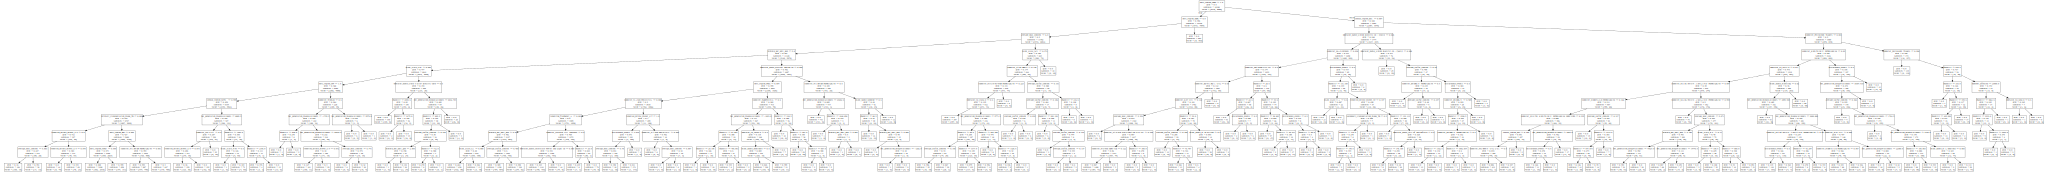

In [201]:
graph = Source(export_graphviz(results, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

In [ ]:
graph.format = 'png'
graph.render('dtree_render',view=True)

In [16]:
X.iloc[0]

average_heat_content                          5.5
average_sulfur_content                        0.0
quantity                                      2.0
naics_code                                   22.0
eia_sector_number                             1.0
net_generation_megawatthours              11336.0
mmbtu_per_unit_gen                            5.5
number_affected                               0.0
disturbance_events                            0.0
contract_type_C                               1.0
contract_type_N/A                             0.0
contract_type_NC                              0.0
contract_type_S                               0.0
energy_source_DFO                             1.0
energy_source_JF                              0.0
energy_source_KER                             0.0
energy_source_OG                              0.0
energy_source_PC                              0.0
energy_source_PG                              0.0
energy_source_RFO                             0.0
